
## Введение

Обучение с подкреплением на данный момент является одним из самых активных направлений исследований в области машинного обучения и нейронных сетей. Сегодня это предмет интереса ученых, занимающихся психологией, теорией управления, искусственным интеллектом и многими другими отраслями знаний.

Ввиду актуальности направления и практического отсутствия материалов по нему в курсе «Технологии машинного обучения» кафедры ИУ5 МГТУ им. Н. Э. Баумана данная тема представила для меня особый интерес.

Данная научно-исследовательская работа посвящена исследованию классических методов обучения с подкреплением на основе временных различий: SARSA-алгоритм, Q-обучение, Expected SARSA, двойное Q-обучение.

## Теоретическая часть



### Основные понятия

Обучение с подкреплением — способ машинного обучения, при котором система обучается, взаимодействуя с некоторой средой.
В обучении с подкреплением существует две стороны: одна, которая обучается и принимает решения, называемая агентом, и вторая, с которой агент взаимодействует, включающая в себя, что находится вне агента, и называемая окружающей средой или просто средой. Обе стороны взаимодействуют непрерывно – агент выбирает действия, а среда реагирует на эти действия и предлагает агенту новые ситуации. Среда также генерирует вознаграждения — числовые значения, которые агент стремится со временем максимизировать посредством выбора действий. [1]

Среда обычно формируется как конечный марковский процесс принятия решений (МППР). В МППР агент и среда взаимодействуют на каждом шаге дискретной последовательности временных шагов, $t$ = 0, 1, 2, 3 … .   На каждом временном шаге $t$ агент получает некоторое представление состояния окружающей среды $S_t \in S$	 и, исходя из него, выбирает действие $A_t \in A(s)$. На следующем шаге агент, отчасти как последствие своего действия, получает числовое вознаграждение $R_{t + 1} \in R \subset \mathbb{R}$ и оказывается в новом состоянии $S_{t + 1}$.


In [1]:
from IPython.display import HTML
HTML('<img src="images/Схема.svg" width=100%>')

В конечном МППР множества состояний, действий и вознаграждений ($S, A, R$) содержат конечное число элементов. Также в марковсоком процессе соблюдается так называемое марковское свойство: вероятность перехода в любое возможное следующее состяние $s' \in S$ зависит только от предыдущего состояния $s \in S$. [2]

В обучении с подкреплением задачи МППР по длительности рабиваются на два класса: эпизодические (последовательность отдельных эпизодов, ограниченных по временным шагам, в которых присутствует заключительное состояние $s' \in S^+$, где $S^+$ — множество всех состояний + заключительное) и непрерывные (количество временных шагов неограниченно). [1] Болле формально данные задачи называются задачами МППР при неопределённом горизонте планирования и при бесконенном горизонте пранирования соответственно. [2]

Основываясь на взаимодействии с окружающей средой, агент, обучающийся с подкреплением, должен выработать такую стратегию $\pi : S \to A$, которая максимизирует доход $G_t = R_{t+1} + R_{t+2} + ... + R_T$, где $T$ — последний временной шаг (эпизода) в случае эпизодической задачи, или доход

$$G_t = \sum_{k = 0}^{+\infty}\gamma^k R_{t+k+1},$$

 где  параметр $\gamma$ — коэффициет обесценивания (дисконтирования), $0 \leq \gamma \leq 1$, для непрерывной задачи.

Стратегия — отображение состояний на вероятности выбора каждого возможного действия. Если агент следует стратегии $\pi$ в момент $t$, то $\pi(a \mid s)$ — вероятность того, что $A_t = a$, если $S_t = s$. Стратегия является обыкновенной функцией; знак $\mid$ в середине выражения $\pi(a \mid s)$ просто напоминает, что она определяет распределение вероятностей $a \in A(s)$ для каждого $s \in S$. [1]

Важным понятием для обучением с подкреплением является функция ценности. Обычно используют две функции ценности: состояний и действий.

Функция ценности состояния $s$ при стратегии $\pi$, обозначаемая $v_\pi(s)$, – это ожидаемый доход, когда агент начинает работу в состоянии $s$ и в дальнейшем следует стратегии $\pi$. Для МППР мы можем формально определить $v_\pi$ следующим образом:

$$v_\pi = \mathbb{E}_\pi[G_t \mid S_t = s] \ \forall s \in S,$$

где $\mathbb{E}_\pi[\cdot]$ — математическое ожидание случайной величины, при условии что агент следует стратегии $\pi$, а $t$ — произвольный временной шаг. Отметим, что ценность заключительного состояния, если оно существует, всегда равна 0. Мы называем функцию $v_\pi$ функцией ценности состояний при стратегии $\pi$.

Аналогично ценность выполнения действия $a$ в состоянии $s$ при стратегии $\pi$, обозначаемая $q_\pi(s, a)$, определяется как ожидаемый доход, когда агент начинает работу в состоянии $s$, предпринимает действие $a$ и затем следует стратегии $\pi$:

$$q_\pi = \mathbb{E}_\pi[G_t \mid S_t = s, A_t = a]$$

Мы называем $q_\pi$ функцией ценности действий при стратегии $\pi$.

Замечание: Функцией ценности состояния можно пользоваться, если нам известна модель окружающей среды в виде так называемой функции динамики среды (МППР) $p(s', r \mid s, a) = P(S_t = s', R_t = r \mid S_{t-1} = s, A_{t - 1} = a)$, для всех $s', s \in S, r \in R, a \in A(s)$ для непрерывной задачи (в эпизодическом случае $s' \in S^+$). Функция $p$, также как и $\pi$ является обыкновенной детеминированной функцией. [1]

Функции ценности $v_\pi$ и $q_\pi$ можно оценить из опыта.

Решение задачи обучения с подкреплением означает, грубо говоря, нахождение стратегии, которая дает большое вознаграждение за длительный период времени.Для конечных МППР можно точно определить оптимальную стратегию следующим образом. Функции ценности определяют отношение частичного порядка на множестве стратегий. Будем говорить, что стратегия $\pi$ больше (лучше) или равна стратегии $\pi'$, если ожидаемый доход для $\pi$ больше или равен ожидаемому доходу для $\pi$ для любого состояния. Иными словами, $\pi \geq \pi'$ тогда и только тогда, когда $v_\pi(s) \geq v_{\pi'}(s)$ для всех $s \in S$. Всегда существует хотя бы одна стратегия, большая или равная всем остальным стратегиям. Это оптимальная стратегия. Хотя оптимальных стратегий может быть несколько, мы обозначаем любую из них $\pi_*$. У них у всех одна и та же функция ценности состояний, которая называется оптимальной функцией ценности состояний, обозначается $v_*$ и определяется следующим образом:

$$v_*(s) = \max_\pi v_\pi(s) \ \forall s \in S$$

У оптимальных стратегий также одна и та же функция ценности действий, которая обозначается $q_*$ и определяется следующим образом:

$$q_*(s, a) = \max_\pi q_\pi(s, a) \ \forall s \in S \wedge \ \forall a \in A(s)$$

Для пары состояние–действие $(s, a)$ эта функция дает ожидаемый доход от выбора действия $a$ в состоянии $s$ и далее следования оптимальной стратегии.

Для $v_*$ и $q_*$ можно написать уравнения оптимальности Беллмана: [1]

$$v_*(s) = \max_a\sum_{s', r}p(s', r \mid s, a)[r + \gamma v_*(s')];$$

$$q_*(s, a) = \sum_{s', r}p(s', r \mid s, a)[r + \gamma \max_{a'} q_*(s', a')].$$

Имея $v_*$, относительно легко определить оптимальную стратегию. Для каждого состояния $s$ будет существовать одно или несколько действий, в которых достигается максимум в уравнении оптимальности Беллмана. Любая стратегия, которая назначает ненулевую вероятность только этим действиям, будет оптимальной. Мы можем считать это одношаговым поиском. Если известна оптимальная функция ценности $v_*$, то действия, которые выглядят лучшими после такого одношагового поиска, и будут оптимальными действиями. По-другому то же самое можно выразить, сказав, что любая стратегия, жадная относительно оптимальной функции ценности $v_*$, является оптимальной. Термин «жадный» употребляется в информатике для описания любой процедуры поиска или принятия решений, которая производит выбор, основываясь только на локальных, или промежуточных, соображениях, не принимая во внимание, что такой выбор может воспрепятствовать отысканию лучших вариантов в будущем [1]. Следовательно, он описывает стратегии, которые выбирают действия, учитывая только краткосрочные последствия. Полезное свойство $v_*$ состоит в том, что если использовать её для вычисления краткосрочных последствий действий, а точнее одношаговых последствий, то жадная стратегия будет оптимальна и в интересующей нас долгосрочной перспективе, поскольку $v_*$ уже учитывает вознаграждения, получаемые в результате всех будущих вариантов поведения. Благодаря $v_*$ оптимальный ожидаемый долгосрочный доход превращается в локальную величину, которая непосредственно доступна для каждого состояния. Поэтому поиск с заглядыванием вперед на один шаг дает оптимальные действия в долгосрочной перспективе.

Зная $q_*$, выбрать оптимальные действия еще проще. В этом случае агенту даже не нужно заглядывать на один шаг вперед: для любого состояния ему достаточно просто найти какое-нибудь действие, доставляющее максимум функции $q_*(s, a)$. Функция ценности действий по существу кеширует результаты всех поисков с заглядыванием на один шаг вперед. Она возвращает оптимальный ожидаемый долгосрочный доход в качестве локального значения, которое непосредственно доступно для каждой пары состояние–действие. Поэтому ценой зависимости от пар состояние–действие, а не просто от состояний, оптимальная функция ценности действий позволяет выбирать оптимальные действия, ничего не зная о возможных последующих состояниях и их ценности, то есть не нуждаясь в информации динамике окружающей среды.

Явное решение уравнения оптимальности Беллмана — один из способов нахождения оптимальной политики, а значит, и решения задачи обучения с подкреплением. Однако, на практике, его практически невозможно найти. В обучении с подкреплением обычно приходится соглашаться на приближенные решения. Многие методы обучения с подкреплением можно интерпретировать как приближенное решение уравнения оптимальности Беллмана с использованием фактически обученных переходов вместо знания ожидаемых переходов.


### Основные стратегии выбора действий

В обучении с подкреплением существует проблема использования и исследования (exploitation vs exploration).

Пусть мы запоминаем ценности действий. Тогда на любом временном шаге имеется по крайней мере одно действие с максимальной оценкой. Назовем эти действия жадными. Если выбирается любое из таких действий, то мы используем текущие знания о ценности действий. Если же выбирается какое-то нежадное действие, то мы занимаемся исследованием, поскольку это позволяет улучшить оценку ценности нежадного действия. Использование дает возможность максимизировать ожидаемое вознаграждение на одном шаге, а исследование может дать большее суммарное вознаграждение в длительной перспективе.

Для достижения компромисса между использованием и исследованием используются стратегии для выбора действий. Самыми простыми являются жадная и $\epsilon$-жадная стратегии. Жадная стратегия выбирает действие с максимальной оценкой, но в таком случае исследование вообще не производится. Простым решением в данном случае применение $\epsilon$-жадной стратегии. Её суть состоит в следующем: с вероятностью $\epsilon \in [0; 1]$ действие выбирается случайно согласно равномерному распределению, а с вероятностью 1 - $\epsilon$ выбирается жадное действие. Если $\epsilon = 0$, то стратегия жадная, а если 1, то выбор действий полностью случаен.

$\epsilon$-жадные стратегии проводят исследования, но без особого разбора. Есть стратегии, которвые обучают предпотчение каждого действия на основе размера награды (стратегия Softmax), или учитывают близость оценок действий к максимальным, так и недостоверность этих оценок (стратегия ВДГ (верхняя доверительная оценка)). [1]

### Обучение на основе временных различий

Обучение на основе временных различий (TD-обучение) – это сочетание идей, заложенных в методах Монте-Карло и динамическом программировании.[1] Как и методы Монте-Карло, методы TD позволяют обучаться непосредственно на опыте, не требуя модели динамики окружающей среды. Как и ДП, методы TD обновляют оценки, основываясь в том числе на других обученных оценках, не дожидаясь конечного результата (бутстрэппинг).

Методы, которые мы будем рассматривать ниже являются одношаговыми TD или TD(0), то есть они совершают полезное обновление (функции ценности) каждый шаг. Все методы не нуждаются в модели окружающей среды и отличаются функциями обновления ценностей и по классу методов: с единой стратегией (on-policy) и с разделённой стратегией (off-policy). Методы с единой стратегией пытаются оценить или улучшить стратегию, которая используется для принятия решений, а методы с разделенной стратегией — оценить или улучшить стратегию, отличную от той, что использовалась для генерации данных. Стратегия в методах с единой стратегией обычно мягкая, то есть $\pi(a \mid s) > 0$ для всех $s \in S$ и всех $a \in A(s)$. В методах с разделённой стратегией обычно используются две стратегии: целевая — стратегия, которой следует обучить, и поведенческая — стратегия, которая генерирует поведение. В данном случае должно соблюдаться предположение о покрытии: из $\pi(a \mid s) > 0$ следует $b(a \mid s) > 0$, где $\pi$ — целевая стратегия, а $b$ — поведенческая.


#### Sarsa

Sarsa — TD-метод обучения с подкреплением с единой стратегией.

В Sarsa используется следующая функция обновления:

$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha[R_{t+1} + Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t)],$$
где $\alpha$ — размер шага

Ниже представлен алгоритм управления Sarsa: [1]
>Параметры алгоритма: размер шага $\alpha \in (0, 1]$, небольшое $\epsilon$ > 0 <br/>
> Инициализировать $Q(s, a)$ для всех $s \in S^+, a \in A(s)$ произвольным образом с ограничением $Q(terminal, \cdot) = 0$ <br/>
> <br/>
>Повторять для каждого эпизода:<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;Инициализировать $S$<br/>
>Выбрать $A$ в состоянии $S$, следуя стратегии, выведенной из $Q$ (например, $\epsilon$-жадной)<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;Повторять для каждого шага эпизода:<br/>
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Предпринять действие $A$, наблюдать $R$, $S'$<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Выбрать $A'$ в $S'$, следуя стратегии, выведенной из $Q$ (например,$\epsilon$-жадной)<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$Q(S, A) \leftarrow Q(S, A) + \alpha[R + Q(S', A) - Q(S, A)]$<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$S \leftarrow S', A \leftarrow A'$;<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;пока состояние $S$ не является заключительным<br/>


#### Q-обучение

Q-обучение — TD-метод обучения с подкреплением с разделённой стратегией.

В Q-обучении используется следующая функция обновления:

$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha[R_{t+1} + \gamma\max_a Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t)],$$
где $\alpha$ — размер шага, $\gamma$ — коэффициент обесценивания. В этом случае обученная функция ценности действий $Q$ непосредственно аппроксимирует $q_*$, оптимальную функцию ценности действий, независимо от того, какой стратегии следует агент.

Ниже представлен алгоритм управления  Q-обучения: [1]
>Параметры алгоритма: размер шага $\alpha \in (0, 1]$, небольшое $\epsilon$ > 0<br/>
> Инициализировать $Q(s, a)$ для всех $s \in S^+, a \in A(s)$ произвольным образом с ограничением $Q(terminal, \cdot) = 0$<br/>
><br/>
>Повторять для каждого эпизода:<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;Инициализировать $S$<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;Повторять для каждого шага эпизода:<br/>
> &nbsp;&nbsp;&nbsp;&nbsp;Выбрать $A$ в состоянии $S$, следуя стратегии, выведенной из $Q$ (например, $\epsilon$-жадной)<br/>
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Предпринять действие $A$, наблюдать $R$, $S'$<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Выбрать $A'$ в $S'$, следуя стратегии, выведенной из $Q$ (например,$\epsilon$-жадной)<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$Q(S, A) \leftarrow Q(S, A) + \alpha[R + \gamma\max_a Q(S', a) - Q(S, A)]$<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$S \leftarrow S'$<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;пока состояние $S$ не является заключительным<br/>

#### Expected Sarsa

Алгоритм Expected Sarsa следует схеме Q-обучения, но вместо максимума вычисляет по парам следующее состояние–действие, вычисляет математическое ожидание, принимая во внимание, с какой вероятностью каждое действие выбирается при текущей стратегии. То есть правило обновления
в этом алгоритме выглядит так:

$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha[R_{t+1} + \gamma\mathbb{E}_\pi [Q(S_{t+1}, A_{t+1}) \mid $S_{t+1}$] - Q(S_t, A_t)],$$

Если следующее состояние $S_{t+1}$, то этот алгоритм детерминированно движется в том же направлении, что и Sarsa в смысле математического ожидания, поэтому называется Expected Sarsa.

Ниже представлен алгоритм управления  Expected Sarsa:
>Параметры алгоритма: размер шага $\alpha \in (0, 1]$, небольшое $\epsilon$ > 0<br/>
> Инициализировать $Q(s, a)$ для всех $s \in S^+, a \in A(s)$ произвольным образом с ограничением $Q(terminal, \cdot) = 0$<br/>
><br/>
>Повторять для каждого эпизода:<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;Инициализировать $S$<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;Повторять для каждого шага эпизода:<br/>
> &nbsp;&nbsp;&nbsp;&nbsp;Выбрать $A$ в состоянии $S$, следуя стратегии, выведенной из $Q$ (например, $\epsilon$-жадной)<br/>
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Предпринять действие $A$, наблюдать $R$, $S'$<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Выбрать $A'$ в $S'$, следуя стратегии, выведенной из $Q$ (например,$\epsilon$-жадной)<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $Q(S, A) \leftarrow Q(S, A) + \alpha[R + \gamma \mathbb{E}_\pi [Q(S', A) \mid S'] - Q(S, A)]$<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$S \leftarrow S'$<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;пока состояние $S$ не является заключительным<br/>

#### Двойное Q-обучение

Все рассмотренные выше алгоритмы управления включают максимизацию в построение целевых стратегий. Например, в Q-обучении целевой является жадная стратегия при известных текущих ценностях действий, а в определении жадностиучаствует операция $\max$. В Sarsa стратегия часто $\epsilon$-жадная, т. е. взятие максимума также присутствует. В этих алгоритмах вычисление максимума по оценкам ценностей используется неявно в виде оценки максимальной ценности, что может приводить к значительному положительному смещению. Чтобы понять, почему это так, рассмотрим одно состояние $s$, в котором имеется много действий $a$, чья истинная ценность $q(s, a)$ всегда равна нулю, а оценки ценности $Q(s, a)$ недостоверны — одни больше, другие меньше нуля. Максимум по истинным ценностям равен 0, но максимум по оценкам положителен, так что налицо положительное смещение, которое называется смещением максимизации.

Идея двойного обучения состоит в разбиении всего множества временных шагов на два подмножества и использования подмножеств для обучения двух независимых оценок, $Q_1(a)$ и $Q_2(a)$, истинной ценности $q(a)$ для всех $a \in A$. Тогда можно было бы взять одну оценку, скажем $Q_1$, для определения доставляющего максимум действия $A^* = \max_a Q_1(a)$, а другую, $Q_2$, – для оценки ценности этого действия, $Q_2(A^*) = Q_2(\max_a Q_1(a))$. Тогда эта оценка будет несмещенной в том смысле, что $\mathbb{E}[Q_2(A^*)] = q(A^*)$. Этот процесс можно повторить, поменяв обе оценки ролями, и получить тем самым вторую несмещенную оценку, $Q_1(\max_a Q_2(a))$.

Ниже представлен алгоритм управления  двойного Q-обучения [1]:
>Параметры алгоритма: размер шага $\alpha \in (0, 1]$, небольшое $\epsilon$ > 0<br/>
> Инициализировать $Q_1(s, a)$ и $Q_2(s, a)$  для всех $s \in S^+, a \in A(s)$ произвольным образом с ограничением $Q(terminal, \cdot) = 0$<br/>
><br/>
>Повторять для каждого эпизода:<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;Инициализировать $S$<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;Повторять для каждого шага эпизода:<br/>
> &nbsp;&nbsp;&nbsp;&nbsp;Выбрать $A$ в состоянии $S$, следуя $\epsilon$-жадной стратегии относительно $Q_1 + Q_2$<br/>
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Предпринять действие $A$, наблюдать $R$, $S'$<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Выбрать $A'$ в $S'$, следуя стратегии, выведенной из $Q$ (например,$\epsilon$-жадной)<br/>
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;C вероятностью 0.5<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$Q_1(S, A) \leftarrow Q_1(S, A) + \alpha[R + \gamma Q_2(S', \max_aQ_1(S', A)] - Q_1(S, A)]$<br/>
>  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;иначе<br/>
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$Q_2(S, A) \leftarrow Q_2(S, A) + \alpha[R + \gamma Q_1(S', \max_aQ_2(S', A)] - Q_2(S, A)]$<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$S \leftarrow S'$<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;пока состояние $S$ не является заключительным<br/>


## Эксперементальная часть

Для экперементирования мы будем использовать библиотеку для обучения с подкреплением на языке *Python*  MushroomRL [3].
Разработчики библиотеки выделяют следующие плюсы:
- Библиотека общего назначения. В ней реализованы обычные и глубокие (deep) алгоритмы обучения с подкреплением. MushroomRL фокусируется на моделировании взаимодействия между средой и агентом [4];
- Легковесность. MushroomRL гибка и дружествена к пользователю;
- Совместимость. Библиотека совместима со следующими библиотеками используемых в RL:
    - Научные вычисления: numpy, scipy;
    - Базовый ML: Scikit-learn;
    - RL-benchmark: OpenAI Gym, DeepMind Control Suite, Pybullet, MuJoCo, ROS;
    - Нейроные сети: PyTorch.
- Легок в обращении.

### Среда изучения

В качестве окружающей среды была выбрана простая игра FrozenLake из OpenAI Gym [5]. В вариации игры 4x4 (которую мы и будем рассматривать) присусвутет 16 состояний следющих типов:
- S: стартовое состояние;
- F: ледяное покрытие;
- H: прорубь;
- G: целевое состояние

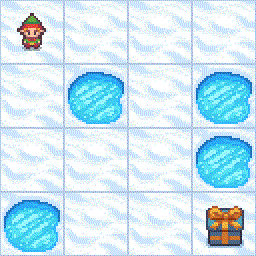

In [2]:
from IPython.display import Image
Image(data='images/frozen_lake.gif')

В данной среде агент может выполнять дейсвтия вверх, вниз, влево, вправо, но так как лёд скользкий, то направление движения агента распределятеся равномерно следющим образом:
Если агент пошёл влево, то в 1/3 случаев переход будет в состояние влево, в 1/3 вверх и в 1/3 вниз. Функцию скольжения можно отключить.

Агент получает награду +1 за переход в G (заверщающее состоятние), 0 за переход между другими состояниями, причём, если агент попадёт в прорубь то эпизод закончится с 0 доходом.


### Импорт библиотек


In [3]:
from mushroom_rl.environments import Gym
from mushroom_rl.policy import EpsGreedy
from mushroom_rl.utils.parameters import Parameter
from mushroom_rl.algorithms.value import SARSA, QLearning, ExpectedSARSA, DoubleQLearning
from mushroom_rl.core import Core
from mushroom_rl.utils.callbacks import CollectDataset
from mushroom_rl.utils.dataset import compute_J, episodes_length, select_first_episodes
from mushroom_rl.utils.table import Table, EnsembleTable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style='ticks')

### Эксперимет №1: Выбор $\epsilon$

Посмотрим какое значение $\epsilon$ для $\epsilon$-жадной стратегии будет наилучшим

In [4]:
def plot_epsilon_experiment(algorithm_class, algorithm_name):
    """
    Функция эксперимента с различными эпсилон и визуализации результатов

    :param algorithm_class: Алгоритм обучения с подкреплением
    :param algorithm_name: Название алгоритма
    """
    eps_list = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
    ep_list = np.arange(100, 10001, 100)
    eps_dict = {}
    eps_mean_J_dict = {}

    # МППР (Окружение)
    mdp = Gym(name='FrozenLake-v1', gamma=1.0, map_name='4x4', is_slippery=True)
    mdp.seed(42)

    # Создание и обучение агентов
    for eps in eps_list:
        pi = EpsGreedy(Parameter(eps))
        alpha = Parameter(value=0.1)
        ag = algorithm_class(mdp.info, pi, alpha)

        collect_data = CollectDataset()
        core = Core(ag, mdp, [collect_data])
        core.learn(n_episodes=10000, n_steps_per_fit=1, quiet=True)

        learn_dataset = collect_data.get()
        eps_dict[eps] = learn_dataset

    # Подсчёт среднего дохода
    for  key, value in eps_dict.items():
        mean_J = []
        for ep in ep_list:
            ep_dataset = select_first_episodes(value, n_episodes=ep)
            mean_J.append(np.mean(compute_J(ep_dataset)))

        eps_mean_J_dict[key] = mean_J

    # Построение графика
    _, ax = plt.subplots(figsize=(7,8))
    for key, value in eps_mean_J_dict.items():
        sns.lineplot(x=ep_list, y=value, ax=ax, label=str(key))
    ax.get_legend().set_title('Эпсилон')
    plt.xlabel('Кол-во эпизодов')
    plt.ylabel('Средний доход')
    plt.title(algorithm_name)
    plt.show()

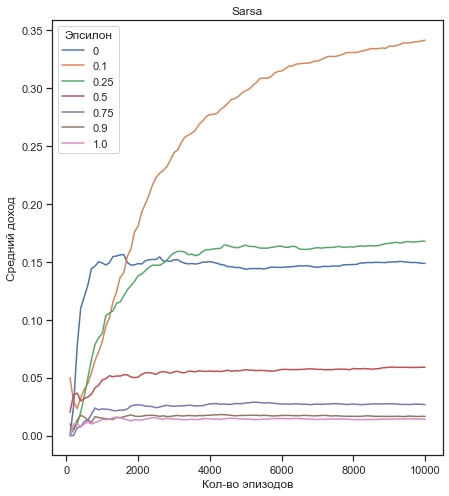

CPU times: total: 2min 42s
Wall time: 2min 47s


In [5]:
%%time
# Sarsa
plot_epsilon_experiment(SARSA, 'Sarsa')

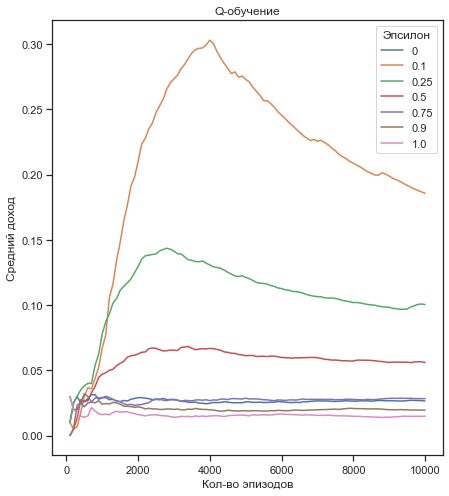

CPU times: total: 2min 40s
Wall time: 2min 45s


In [6]:
%%time
# Q-обучение
plot_epsilon_experiment(QLearning, 'Q-обучение')

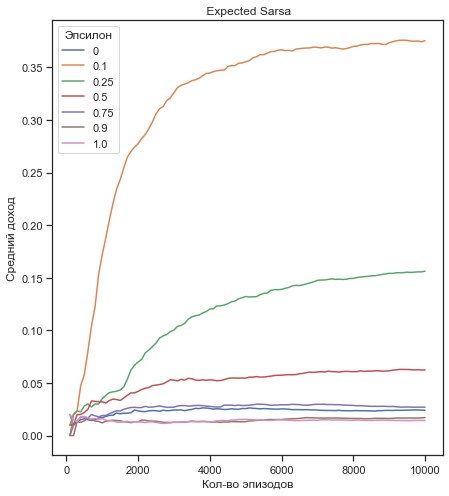

CPU times: total: 2min 47s
Wall time: 2min 54s


In [7]:
%%time
# Expected Sarsa
plot_epsilon_experiment(ExpectedSARSA, ' Expected Sarsa')

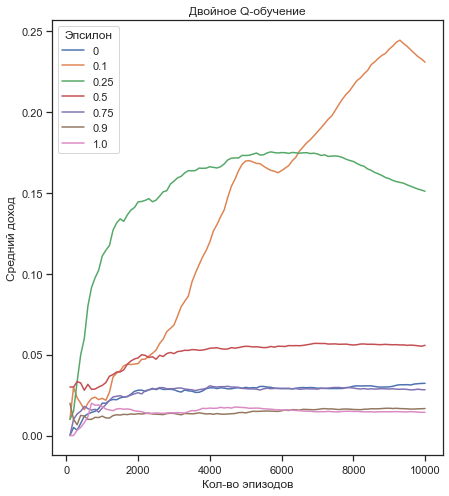

CPU times: total: 2min 54s
Wall time: 2min 59s


In [8]:
%%time
# Двойное Q-обучение
plot_epsilon_experiment(DoubleQLearning, 'Двойное Q-обучение')

Для всех моделей $\epsilon$ = 0.1 оказалась лучшей.


### Эксперимент №2: Выбор лучшей модели


In [9]:
def experiment(algorithm_class, epsilon_value, learning_rate_value, gamma_value):
    """
    Фунция эксперимета с некоторым алгоритмом обучения с подкреплением

    :param algorithm_class: Алгоритм обучения с подкреплением
    :param epsilon_value: Значение эпсилон для стратегии
    :param learning_rate_value: Размер шага
    :param gamma_value: Коэффициент обесченивания
    :return: Средние значения доходов и шагов в эпизодах за время обучения,
    финальные Q-таблицы,
    среднее значение доходов и шагов в эпизодах за время тестирования
    """
    # МППР (Окружение)
    mdp = Gym(name='FrozenLake-v1', gamma=gamma_value,
              map_name='4x4', is_slippery=True)
    mdp.seed(42)

    # Стратегия
    epsilon = Parameter(value=epsilon_value)
    policy = EpsGreedy(epsilon)

    # Агент
    learning_rate = Parameter(value=learning_rate_value)
    agent = algorithm_class(mdp.info, policy, learning_rate)

    # Callback для врзвращения данных при обучении
    collect_dataset = CollectDataset()
    callbacks = [collect_dataset]

    # Обучение
    core = Core(agent, mdp, callbacks)
    core.learn(n_episodes=10000, n_steps_per_fit=1, quiet=True)

    # Набор данных обучения
    learn_dataset = collect_dataset.get()

    # Подсчёт среднего дохода и среднего количества шагов в эпизодах
    ep_list = np.arange(100, 10001, 100)
    mean_j_list = []
    mean_steps_list = []
    for ep in ep_list:
        ep_dataset = select_first_episodes(learn_dataset, n_episodes=ep)
        mean_j_list.append(np.mean(compute_J(ep_dataset, gamma=mdp.info.gamma)))
        mean_steps_list.append(np.mean(episodes_length(ep_dataset)))

    # Получение финальной таблицы значений действий Q
    q = None
    if type(agent.Q) == EnsembleTable:
        shape = agent.Q[0].shape
        q = [np.zeros(shape), np.zeros(shape)]
        for t in range(0, 2):
            for i in range(shape[0]):
                for j in range(shape[1]):
                    state = np.array([i])
                    action = np.array([j])
                    q[t][i, j] = agent.Q[t].predict(state, action)
    elif type(agent.Q) == Table:
        shape = agent.Q.shape
        q = np.zeros(shape)
        for i in range(shape[0]):
            for j in range(shape[1]):
                state = np.array([i])
                action = np.array([j])
                q[i, j] = agent.Q.predict(state, action)

    # Тестирование обученного агента
    if algorithm_class == SARSA or algorithm_class == ExpectedSARSA:
        policy.set_epsilon(Parameter(0.0))
    else:
        policy.set_q(agent.Q)
    eval_dataset = core.evaluate(n_episodes=1000, quiet=True)
    mean_j_eval = np.mean(compute_J(eval_dataset, gamma=mdp.info.gamma))
    mean_steps_eval = np.mean(episodes_length(eval_dataset))

    return mean_j_list, mean_steps_list, q, mean_j_eval, mean_steps_eval

In [10]:
def plot_qtable_heatmap(q_table, algorithm_name):
    """
    Функция визуализации таблицы ценностей действий Q с помощью тепловой карты

    :param q_table: Таблица Q
    :param algorithm_name: Название алгоритма обучения с подкреплением
    """
    if q_table is not None:
        columns = ['LEFT', 'DOWN', 'RIGHT', 'UP']
        if len(q_table) == 2:
            q1_df = pd.DataFrame(data=q_table[0], columns=columns)
            q2_df = pd.DataFrame(data=q_table[1], columns=columns)
            fig, ax = plt.subplots(1, 2, figsize=(16,6))
            sns.heatmap(data=q1_df, annot=True, fmt='.3f', vmin=0.0, vmax=1.0,
                        cmap='Blues', ax=ax[0])
            sns.heatmap(data=q2_df, annot=True, fmt='.3f', vmin=0.0, vmax=1.0,
                        cmap='Blues', ax=ax[1])
            fig.suptitle(algorithm_name)
            ax[0].title.set_text('Таблица Q1')
            ax[0].set_xlabel('Действие')
            ax[0].set_ylabel('Состояние')
            ax[1].title.set_text('Таблица Q2')
            ax[1].set_xlabel('Действие')
            ax[1].set_ylabel('Состояние')
        else:
            q_df = pd.DataFrame(data=q_table, columns=columns)
            plt.figure(figsize=(8,6))
            sns.heatmap(data=q_df, annot=True, fmt='.3f',
                        vmin=0.0, vmax=1.0, cmap='Blues')
            plt.xlabel('Действие')
            plt.ylabel('Состояние')
            plt.title(algorithm_name)
        plt.show()

In [11]:
# начальные переменные
algoritms_list = [SARSA, QLearning, ExpectedSARSA, DoubleQLearning]
algoritms_names_list = ['Sarsa', 'Q-обучение',
                        'Expected Sarsa', 'Двойное Q-обучение']
mean_J_dict = {}
mean_steps_dict = {}
q_dict = {}
mean_j_eval_list = []
mean_steps_eval_list = []

In [12]:
# Проведение эксперимента
for name, alg in zip(algoritms_names_list, algoritms_list):
    mean_J_dict[name], mean_steps_dict[name], q_dict[name], \
    mean_j_eval, mean_steps_eval  = \
        experiment(algorithm_class=alg, epsilon_value=0.1,
                   gamma_value=1.0, learning_rate_value=0.1)
    mean_j_eval_list.append(mean_j_eval)
    mean_steps_eval_list.append(mean_steps_eval)

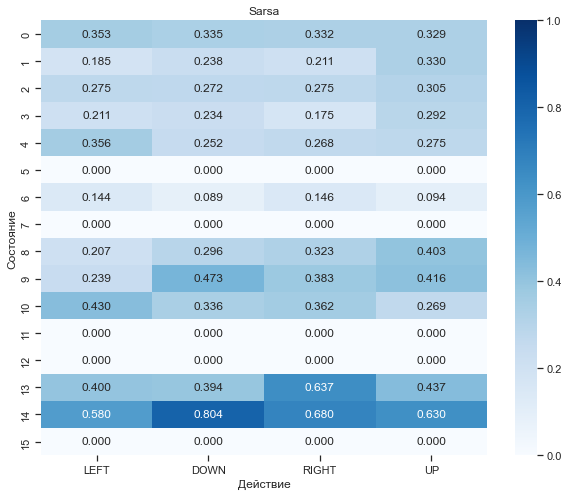

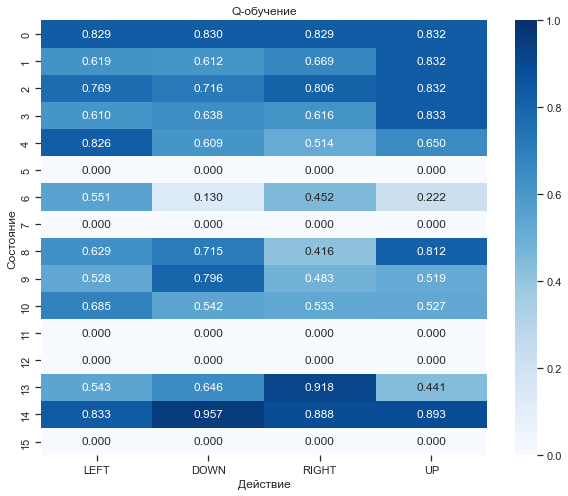

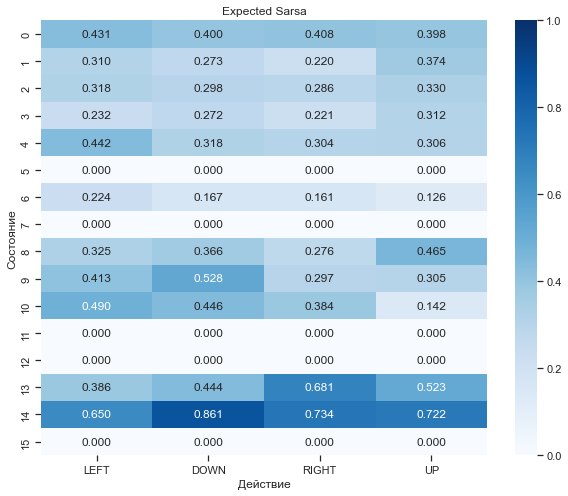

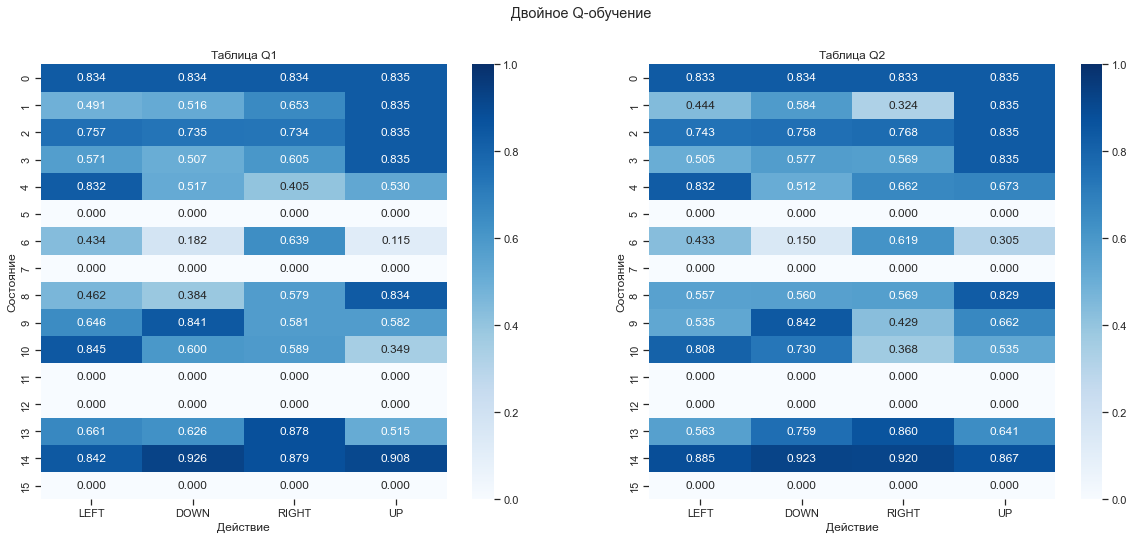

In [13]:
# Тепловые карты таблиц Q
for name in algoritms_names_list:
    plot_qtable_heatmap(q_dict[name], name)

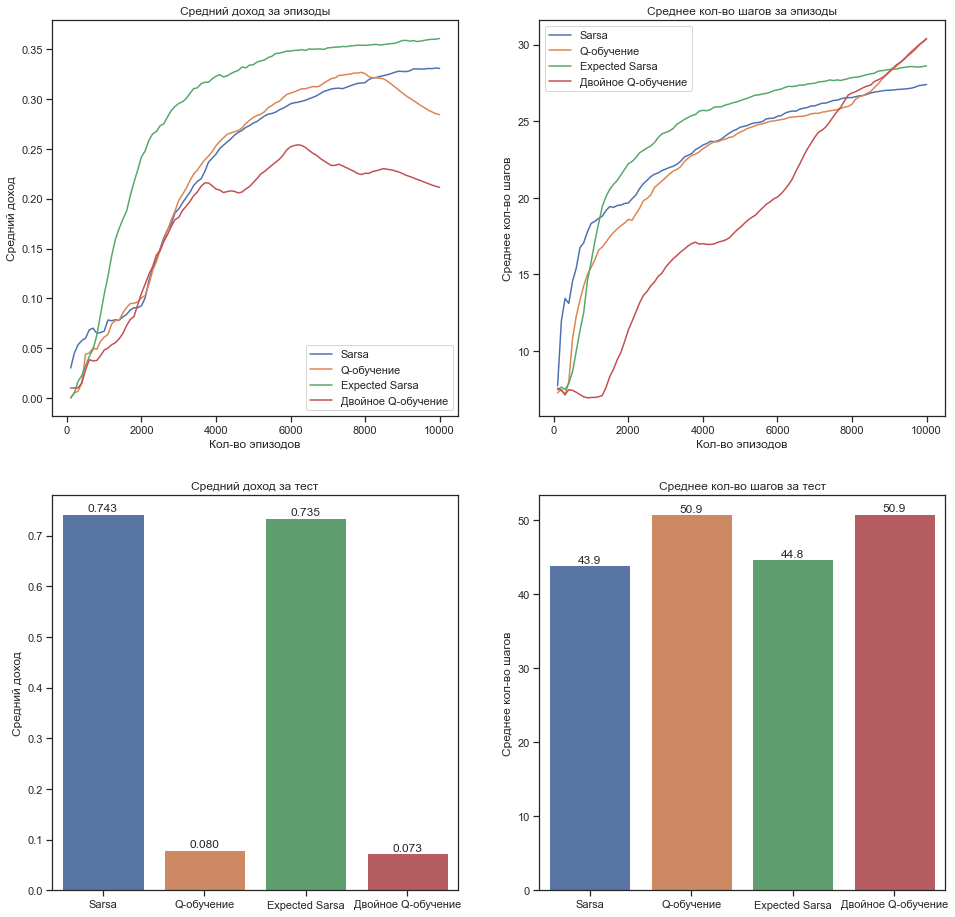

In [56]:
episode_list = np.arange(100, 10001, 100)
fig, ax = plt.subplots(2, 2, figsize=(16,16))

for name in algoritms_names_list:
    sns.lineplot(x=episode_list, y=mean_J_dict[name], label=name, ax=ax[0,0])
    sns.lineplot(x=episode_list, y=mean_steps_dict[name], label=name, ax=ax[0, 1])

bar1 = sns.barplot(x=algoritms_names_list,y=mean_j_eval_list, ax=ax[1,0])
bar2 = sns.barplot(x=algoritms_names_list,y=mean_steps_eval_list, ax=ax[1,1])
bar1.bar_label(bar1.containers[-1], fmt='%.3f')
bar2.bar_label(bar2.containers[-1], fmt='%.1f')

ax[0, 0].title.set_text('Средний доход за эпизоды')
ax[0, 0].set_xlabel('Кол-во эпизодов')
ax[0, 0].set_ylabel('Средний доход')
ax[0, 1].title.set_text('Среднее кол-во шагов за эпизоды')
ax[0, 1].set_xlabel('Кол-во эпизодов')
ax[0, 1].set_ylabel('Среднее кол-во шагов')
ax[1, 0].title.set_text('Средний доход за тест')
ax[1, 0].set_ylabel('Средний доход')
ax[1, 1].title.set_text('Среднее кол-во шагов за тест')
ax[1, 1].set_ylabel('Среднее кол-во шагов')
plt.show()

В данном эксперимент лучшими оказались агенты обученные по алгоритмам Sarsa и Expected Sarsa. Предположительно плохое качесвто Q-обучений связано с отпимальной стратегией $\pi_*$, которая использовалась при тесте. Подробнее смотри пример 6.6 "Блуждание на краю обрыва." из [1].

## Заключение

В результате проделанной работы были изучены основные концнпты обучения с подкреплением. Методы обучения с подкреплением на основе временных различий были рассмотрены. Результаты работы агентов были расчитаны  и оценены. Был приобретён опыт работы с библиотеками для обучения с подкреплением для языка программирования *Python*.


## Список использованных источников информации

1. Саттон Р. С., Барто Э. Дж. Обучение с подкреплением: Введение. 2-е изд. / пер. с англ. А. А. Слинкина. – М.: ДМК Пресс, 2020. – 552 с.: ил.;
2. Волков И. К., Загоруйко Е. А. Исследование операций: Учеб. для вузов / Под ред. В. С. Забурина, А. П. Крищенко. – М.: Изд-во МГТУ им. Н. Э. Баумана, 2000. – 436 с. (Сер. Математика в техническом унивеситете; Вып. XX);
3. Carlo D’Eramo, Davide Tateo, Andrea Bonarini, Marcello Restelli, Jan Peters. MushroomRL: Simplifying Reinforcement Learning Research. arXiv preprint arXiv:2001.01102v2, 2020;
4. MushroomRL documentation [Official site]. URL: https://mushroomrl.readthedocs.io/en/latest/index.html (дата обращения: 05.06.2022);
5. Gym documentation [Official site]. URL: https://www.gymlibrary.ml/ (дата обращения: 05.06.2022);